In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import teotil3 as teo

plt.style.use("ggplot")

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Compare methods for estimating losses from aquaculture

The current approach for aquaculture is described on page 29 of [this report](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/2985726/7726-2022+high.pdf?sequence=1#page=29). It's quite complicated/fiddly and the input data are messy. This notebook explores a simpler calculation that uses just data describing feed use and production (`FORFORBRUK_KILO` and `UTTAK_KILO`, respectively).

The original method is fine and gives sensible results, but a simpler method might be more transparent and it's probably just as accurate. The simple approach also has the advantage of relying on things that are easily measured (amounts of food added and fish produced), instead of estimates of e.g. number of fish that escape, which is presumably uncertain.

In [4]:
st_yr, end_yr = 2013, 2023

In [5]:
def calculate_aquaculture_losses(row, k_feed, k_prod, fcr):
    """Simplified calculation for N and P losses. Similar to the way TOC
    losses are estimated.
    """
    if not isinstance(k_feed, (int, float)):
        raise TypeError("'k_feed' must be a number.")
    if not isinstance(fcr, (int, float)):
        raise TypeError("'fcr' must be a number.")

    if (row["feed_added_kg"] == 0) and (row["production_kg"] == 0):
        return 0
    elif (row["feed_added_kg"] == 0) and (row["production_kg"] > 0):
        # Use FCR to estimate actual feed use
        feed_use = fcr * row["production_kg"]
        return feed_use * (k_feed - k_prod / fcr)
    else:
        # Use actual feed use values
        return row["feed_added_kg"] * (k_feed - k_prod / fcr)

In [6]:
df_list = []
for year in range(st_yr, end_yr + 1):
    # Get results from the "full" calculation from the database
    teo_df = teo.io.get_raw_annual_point_data(
        eng,
        year,
        "aquaculture",
        par_list=[
            "totn_kg",
            "totp_kg",
        ],
    )

    # Read raw data from FDir
    xl_path = f"/home/jovyan/shared/common/teotil3/point_data/{year}/fiske_oppdret_{year}_raw.xlsx"
    fdir_df = pd.read_excel(xl_path, sheet_name=f"fiskeoppdrett_{year}")

    # Rename
    names_dict = {
        "AAR": "year",
        "LOKNR": "site_id",
        "FISKEARTID": "species",
        "FORFORBRUK_KILO": "feed_added_kg",
        "UTTAK_KILO": "production_kg",
    }
    fdir_df = fdir_df.rename(columns=names_dict)[names_dict.values()]

    # Convert dtypes
    fdir_df["site_id"] = fdir_df["site_id"].astype(str)

    # Filter to species of interest
    spec_list = [71401, 71101]
    fdir_df = fdir_df.query("species in @spec_list")
    del fdir_df["species"]

    # Fill NaNs
    fdir_df["feed_added_kg"] = fdir_df["feed_added_kg"].fillna(0)
    fdir_df["production_kg"] = fdir_df["production_kg"].fillna(0)

    # Aggregate to annual
    fdir_df = fdir_df.groupby(["year", "site_id"]).sum().reset_index()

    # Annual FCR
    fcr = fdir_df["feed_added_kg"].sum() / fdir_df["production_kg"].sum()
    print(f"FCR in {year}: {fcr}.")

    # Get coefficients
    coeff_df = teo.preprocessing.read_aquaculture_coefficients()
    k_feed_n = coeff_df.loc["k_feed_n"]["value"]
    k_feed_p = coeff_df.loc["k_feed_p"]["value"]
    k_feed_c = coeff_df.loc["k_feed_c"]["value"]
    k_prod_n = coeff_df.loc["k_prod_n"]["value"]
    k_prod_p = coeff_df.loc["k_prod_p"]["value"]
    default_fcr = coeff_df.loc["fcr"]["value"]

    if fcr < 1:
        fcr = default_fcr

    # Simple method for estimating N and P losses
    fdir_df["TOTP_kg"] = fdir_df.apply(
        calculate_aquaculture_losses,
        args=(k_feed_p, k_prod_p, fcr),
        axis=1,
    )
    fdir_df["TOTN_kg"] = fdir_df.apply(
        calculate_aquaculture_losses,
        args=(k_feed_n, k_prod_n, fcr),
        axis=1,
    )

    # Join to results from "full" calculation
    df = pd.merge(
        teo_df,
        fdir_df[["site_id", "TOTP_kg", "TOTN_kg"]],
        on="site_id",
        how="inner",
        suffixes=("_teo", "_new"),
    )
    df["year"] = year

    df_list.append(df)

# Merge
df = pd.concat(df_list, axis="rows")
df.head()

FCR in 2013: 1.2769715079923707.
FCR in 2014: 1.2564945462846873.
FCR in 2015: 1.2402440582001266.
FCR in 2016: 1.2625552648132448.
FCR in 2017: 1.2973000699481787.
FCR in 2018: 1.2550706007615942.
FCR in 2019: 1.1975047433923307.
FCR in 2020: 1.2498077319158138.
FCR in 2021: 1.1936982191837886.
FCR in 2022: 0.9145373164405154.
FCR in 2023: 1.1663772646510464.


,site_id,site_name,sector,type,site_x_utm33,site_y_utm33,outlet_x_utm33,outlet_y_utm33,year,regine,TOTN_kg_teo,TOTP_kg_teo,TOTP_kg_new,TOTN_kg_new
0,10029,Tuholmane,Aquaculture,Fiskeoppdrett i sjøvann,-55087.580094,6.622440e+06,-55087.580094,6.622440e+06,2013,040.2,67359.1,11461.1,10278.297560,59578.838992
1,10041,KVIKSHOLMEN,Aquaculture,Fiskeoppdrett i sjøvann,-50420.519900,6.698858e+06,-50420.519900,6.698858e+06,2013,054.1,43129.6,7432.6,7373.593258,42741.526305
2,10045,Eidholmen,Aquaculture,Fiskeoppdrett i sjøvann,-48204.800111,6.702341e+06,-48204.800111,6.702341e+06,2013,054.1,14715.7,2536.8,2523.074477,14625.169892
3,10054,2105 TOBBEHOLMANE,Aquaculture,Fiskeoppdrett i sjøvann,-38894.029244,6.693743e+06,-38894.029244,6.693743e+06,2013,054.2,11240.4,1963.2,2141.602629,12413.942821
4,10078,Mjånes,Aquaculture,Fiskeoppdrett i sjøvann,-37801.948210,6.803609e+06,-37801.948210,6.803609e+06,2013,068.91,39656.3,6804.4,6530.129917,37852.334651


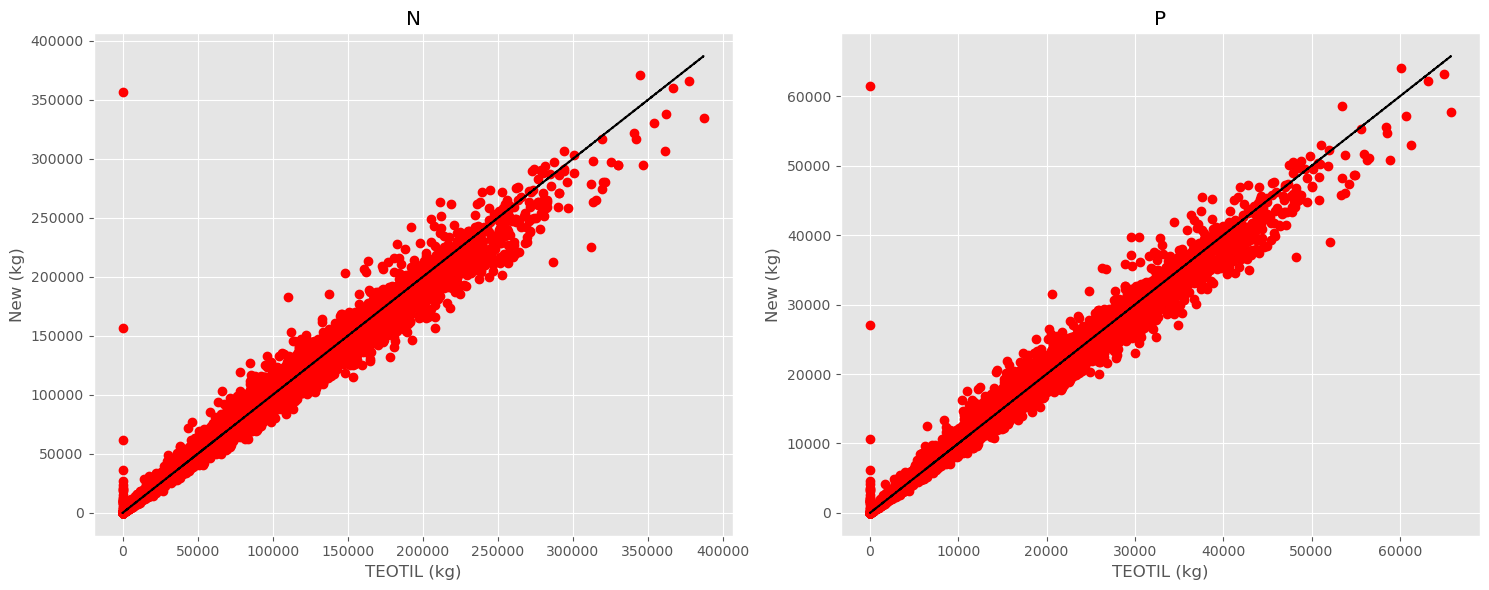

In [7]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].plot(df["TOTN_kg_teo"], df["TOTN_kg_new"], "ro")
axes[0].plot(df["TOTN_kg_teo"], df["TOTN_kg_teo"], "k--")
axes[0].set_xlabel("TEOTIL (kg)")
axes[0].set_ylabel("New (kg)")
axes[0].set_title("N")

axes[1].plot(df["TOTP_kg_teo"], df["TOTP_kg_new"], "ro")
axes[1].plot(df["TOTP_kg_teo"], df["TOTP_kg_teo"], "k--")
axes[1].set_xlabel("TEOTIL (kg)")
axes[1].set_ylabel("New (kg)")
axes[1].set_title("P")

plt.tight_layout()

In [8]:
print("TOTN:", 100 * df["TOTN_kg_new"].sum() / df["TOTN_kg_teo"].sum())
print("TOTP:", 100 * df["TOTP_kg_new"].sum() / df["TOTP_kg_teo"].sum())

TOTN: 99.69363418071006
TOTP: 99.99384089670303


## Summary

Both methods produce similar results. The "full" calculation currently used is perhaps slightly better, because it uses monthly production data where available, but otherwise falls back to using a simpler method based on the FCR, which is similar to the alternative explored here. However, for practical purposes, the simple method gives the same answer and involves a calculation that is easier to code, debug, and explain. It also requires less input data and is more compatible with the way losses of TOC are estimated.